# Final Project - James He

## Part 1:

You shall use TensorFlow APIs to imitate Fig. 4 in the paper for ResNet-50 and ResNet-101 and reproduce the results in Tab. 3 and Tab. 4 for both ResNet-50 and ResNet-101 and discuss your experiment.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Define preprocess_input for ResNet specific preprocessing
def preprocess_input(image):
    # Normalize pixel values to range [0, 1]
    return image / 255.0

def preprocess_image(image, label):
    """
    Preprocess the image: Resize and Normalize
    """
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)  # ResNet specific preprocessing
    return image, label

def load_cifar_dataset(dataset_name="cifar10", batch_size=32, validation_split=0.1):
    if dataset_name == "cifar10":
        (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    elif dataset_name == "cifar100":
        (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    # Splitting training set into training and validation
    num_validation_samples = int(len(train_images) * validation_split)

    validation_images = train_images[:num_validation_samples]
    validation_labels = train_labels[:num_validation_samples]
    train_images = train_images[num_validation_samples:]
    train_labels = train_labels[num_validation_samples:]

    # Create a tf.data.Dataset object for both training and testing data
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    # Apply preprocessing using the map function
    train_dataset = train_dataset.map(preprocess_image).batch(batch_size)
    validation_dataset = validation_dataset.map(preprocess_image).batch(batch_size)
    test_dataset = test_dataset.map(preprocess_image).batch(batch_size)

    return train_dataset, validation_dataset, test_dataset

In [ ]:
# Define the identity block
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)

    # Second component of main path
    X = layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path
    X = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X

# Define the convolutional block
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = layers.Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)

    # Second component of main path
    X = layers.Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path
    X = layers.Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = layers.Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1')(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X

### Resnet50 structure:

Conv 1: 7 x 7, 64, stride = 2

Conv 2: \\
3 x 3 max pool, stride = 2 \\
        [(1 x 1, 64), \\
         (3 x 3, 64), \\
         (1 x 1, 256)] x 3

Conv 3: \\
        [(1 x 1, 128), \\
         (3 x 3, 128), \\
         (1 x 1, 512)] x 4

Conv 4: \\
        [(1 x 1, 256), \\
         (3 x 3, 256), \\
         (1 x 1, 1024)] x 6

Conv 5: \\
        [(1 x 1, 512), \\
         (3 x 3, 512), \\
         (1 x 1, 2048)] x 3


In [ ]:
def ResNet50(input_shape=(224, 224, 3), classes=10):
    X_input = layers.Input(input_shape)

    # Conv 1
    X = layers.ZeroPadding2D((3, 3))(X_input)
    X = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)

    # Conv 2
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, 3, [64, 64, 256], stage=2, block='a', s=1)
    for i in range(2):
        X = identity_block(X, 3, [64, 64, 256], stage=2, block=chr(98 + i))

    # Conv 3
    X = convolutional_block(X, 3, [128, 128, 512], stage=3, block='a')
    for i in range(3):
        X = identity_block(X, 3, [128, 128, 512], stage=3, block=chr(98 + i))

    # Conv 4
    X = convolutional_block(X, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(5):
        X = identity_block(X, 3, [256, 256, 1024], stage=4, block=chr(98 + i))

    # Conv 5
    X = convolutional_block(X, 3, [512, 512, 2048], stage=5, block='a')
    for i in range(2):
        X = identity_block(X, 3, [512, 512, 2048], stage=5, block=chr(98 + i))

    # Average pooling
    X = layers.GlobalAveragePooling2D()(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc' + str(classes))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet101')

    return model

In [ ]:
# Load CIFAR-10 dataset
train_dataset, validation_dataset, test_dataset = load_cifar_dataset("cifar10")

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
# Create ResNet50 model
resnet50_model = ResNet50(input_shape=(224, 224, 3), classes=10)

# Compile the model
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy,tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top-1-acc'), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top-5-acc')])

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)

# Train the model with TensorBoard callback
resnet50_history = resnet50_model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[tensorboard_callback])

# Evaluate the model on the test dataset
loss, accuracy, top_1_accuracy, top_5_accuracy = resnet50_model.evaluate(test_dataset)
print(f"Top-1 Error: {1 - top_1_accuracy:.4f}")
print(f"Top-5 Error: {1 - top_5_accuracy:.4f}")
print(f"Test Accuracy: {accuracy}")

# Save the model
resnet50_model.save('resnet50.keras')


Epoch 1/20
1407/1407 [==============================] - 137s 72ms/step - loss: 1.8077 - categorical_accuracy: 0.3512 - top-1-acc: 0.3512 - top-5-acc: 0.8587 - val_loss: 2.0692 - val_categorical_accuracy: 0.3299 - val_top-1-acc: 0.3299 - val_top-5-acc: 0.8781
Epoch 2/20
1407/1407 [==============================] - 97s 69ms/step - loss: 1.2847 - categorical_accuracy: 0.5358 - top-1-acc: 0.5358 - top-5-acc: 0.9433 - val_loss: 1.8532 - val_categorical_accuracy: 0.4263 - val_top-1-acc: 0.4263 - val_top-5-acc: 0.8809
Epoch 3/20
1407/1407 [==============================] - 97s 69ms/step - loss: 0.9355 - categorical_accuracy: 0.6681 - top-1-acc: 0.6681 - top-5-acc: 0.9724 - val_loss: 1.0045 - val_categorical_accuracy: 0.6508 - val_top-1-acc: 0.6508 - val_top-5-acc: 0.9750
Epoch 4/20
1407/1407 [==============================] - 97s 69ms/step - loss: 0.7403 - categorical_accuracy: 0.7399 - top-1-acc: 0.7399 - top-5-acc: 0.9840 - val_loss: 1.0641 - val_categorical_accuracy: 0.6605 - val_top-1-acc

### Resnet101 structure:

Conv 1: 7 x 7, 64, stride = 2

Conv 2: \\
3 x 3 max pool, stride = 2 \\
        [(1 x 1, 64), \\
         (3 x 3, 64), \\
         (1 x 1, 256)] x 3

Conv 3: \\
        [(1 x 1, 128), \\
         (3 x 3, 128), \\
         (1 x 1, 512)] x 4

Conv 4: \\
        [(1 x 1, 256), \\
         (3 x 3, 256), \\
         (1 x 1, 1024)] x 23



Conv 5: \\
        [(1 x 1, 512), \\
         (3 x 3, 512), \\
         (1 x 1, 2048)] x 3


In [ ]:
def ResNet101(input_shape=(224, 224, 3), classes=10):
    X_input = layers.Input(input_shape)

    # Conv 1
    X = layers.ZeroPadding2D((3, 3))(X_input)
    X = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)

    # Conv 2
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, 3, [64, 64, 256], stage=2, block='a', s=1)
    for i in range(2):
        X = identity_block(X, 3, [64, 64, 256], stage=2, block=chr(98 + i))

    # Conv 3
    X = convolutional_block(X, 3, [128, 128, 512], stage=3, block='a')
    for i in range(3):
        X = identity_block(X, 3, [128, 128, 512], stage=3, block=chr(98 + i))

    # Conv 4
    X = convolutional_block(X, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(22):
        X = identity_block(X, 3, [256, 256, 1024], stage=4, block=chr(98 + i))

    # Conv 5
    X = convolutional_block(X, 3, [512, 512, 2048], stage=5, block='a')
    for i in range(2):
        X = identity_block(X, 3, [512, 512, 2048], stage=5, block=chr(98 + i))

    # Average pooling
    X = layers.GlobalAveragePooling2D()(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc' + str(classes))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet101')

    return model

In [ ]:
# Create ResNet101 model
resnet101_model = ResNet101(input_shape=(224, 224, 3), classes=10)

# Compile the model
resnet101_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy,tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top-1-acc'), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top-5-acc')])

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)

# Train the model with TensorBoard callback
resnet101_history = resnet101_model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[tensorboard_callback])

# Evaluate the model on the test dataset
loss, accuracy, top_1_accuracy, top_5_accuracy = resnet101_model.evaluate(test_dataset)
print(f"Top-1 Error: {1 - top_1_accuracy:.4f}")
print(f"Top-5 Error: {1 - top_5_accuracy:.4f}")
print(f"Test Accuracy: {accuracy}")

# Save the model
resnet101_model.save('resnet101.keras')


Epoch 1/20
1407/1407 [==============================] - 223s 114ms/step - loss: 1.7303 - categorical_accuracy: 0.3787 - top-1-acc: 0.3787 - top-5-acc: 0.8737 - val_loss: 252.2337 - val_categorical_accuracy: 0.1270 - val_top-1-acc: 0.1270 - val_top-5-acc: 0.7524
Epoch 2/20
1407/1407 [==============================] - 159s 113ms/step - loss: 1.2423 - categorical_accuracy: 0.5562 - top-1-acc: 0.5562 - top-5-acc: 0.9451 - val_loss: 3.2592 - val_categorical_accuracy: 0.2614 - val_top-1-acc: 0.2614 - val_top-5-acc: 0.7503
Epoch 3/20
1407/1407 [==============================] - 159s 113ms/step - loss: 0.9652 - categorical_accuracy: 0.6573 - top-1-acc: 0.6573 - top-5-acc: 0.9696 - val_loss: 3.5896 - val_categorical_accuracy: 0.3325 - val_top-1-acc: 0.3325 - val_top-5-acc: 0.7582
Epoch 4/20
1407/1407 [==============================] - 159s 113ms/step - loss: 0.8346 - categorical_accuracy: 0.7080 - top-1-acc: 0.7080 - top-5-acc: 0.9789 - val_loss: 1.0924 - val_categorical_accuracy: 0.6527 - val_

In [ ]:
print(resnet50_history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'top-1-acc', 'top-5-acc', 'val_loss', 'val_categorical_accuracy', 'val_top-1-acc', 'val_top-5-acc'])


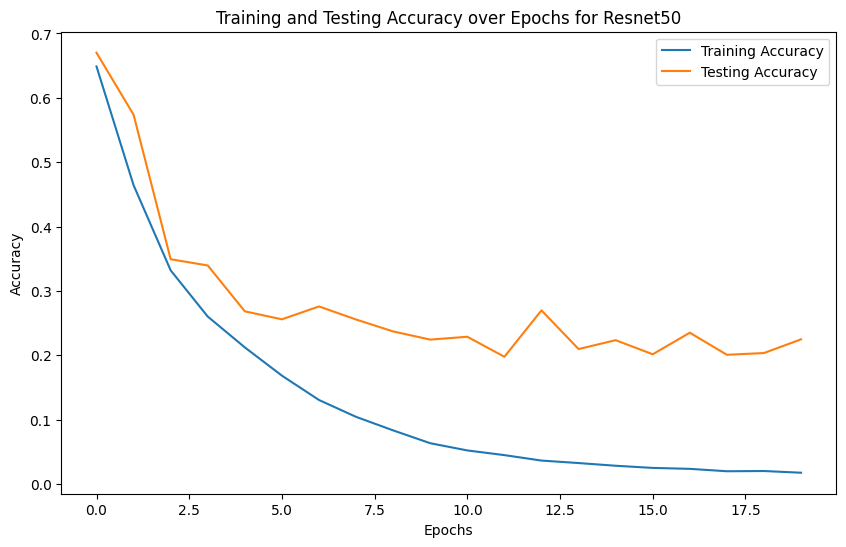

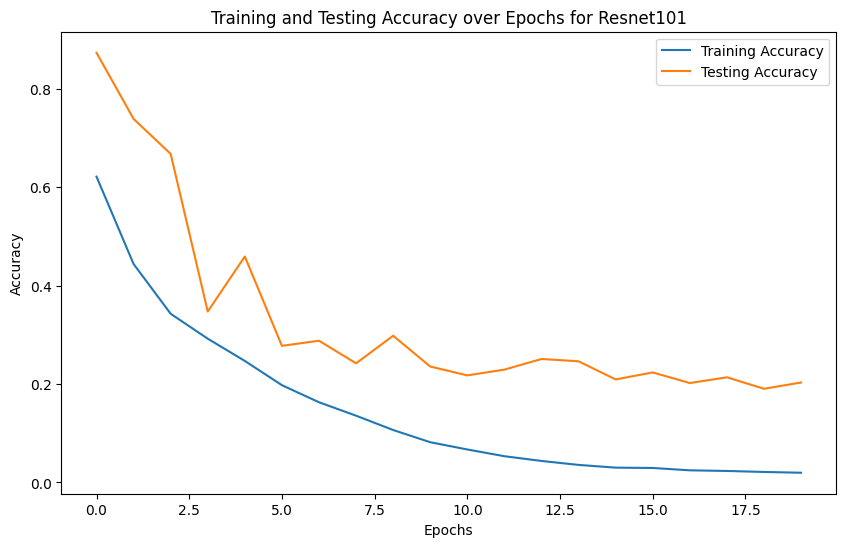

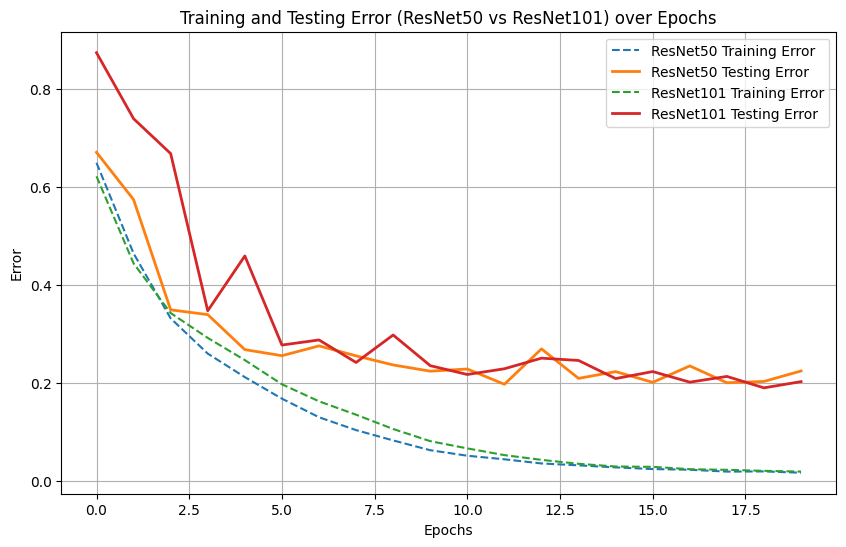

In [ ]:
import matplotlib.pyplot as plt

resnet101_training_error = [1 - acc for acc in resnet101_history.history['categorical_accuracy']]
resnet101_testing_error = [1 - acc for acc in resnet101_history.history['val_categorical_accuracy']]

resnet50_training_error = [1 - acc for acc in resnet50_history.history['categorical_accuracy']]
resnet50_testing_error = [1 - acc for acc in resnet50_history.history['val_categorical_accuracy']]

# Plot resnet 50
plt.figure(figsize=(10, 6))

plt.plot(resnet50_training_error, label='Training Accuracy')
plt.plot(resnet50_testing_error, label='Testing Accuracy')

plt.title('Training and Testing Accuracy over Epochs for Resnet50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Plot resnet 101
plt.figure(figsize=(10, 6))

plt.plot(resnet101_training_error, label='Training Accuracy')
plt.plot(resnet101_testing_error, label='Testing Accuracy')

plt.title('Training and Testing Accuracy over Epochs for Resnet101')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))

plt.plot(resnet50_training_error, label='ResNet50 Training Error', linestyle='--')
plt.plot(resnet50_testing_error, label='ResNet50 Testing Error', linewidth=2)
plt.plot(resnet101_training_error, label='ResNet101 Training Error', linestyle='--')
plt.plot(resnet101_testing_error, label='ResNet101 Testing Error', linewidth=2)

plt.title('Training and Testing Error (ResNet50 vs ResNet101) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Preprocessing function with 10-crop logic included
def preprocess_image_10_crop(image, label):
    image = tf.image.resize(image, [256, 256])

    offsets = [[0, 0], [0, 256-224], [256-224, 0], [256-224, 256-224], [256//2-224//2, 256//2-224//2]]
    crops = []

    for offset in offsets:
        for flip_horizontal in [False, True]:
            cropped = tf.image.crop_to_bounding_box(image, offset[0], offset[1], 224, 224)
            if flip_horizontal:
                cropped = tf.image.flip_left_right(cropped)
            crops.append(cropped)

    replicated_label = tf.repeat(tf.expand_dims(label, axis=0), repeats=10, axis=0)


    # Use tf.stack to convert the list of crops to a 4D tensor
    crops = tf.stack(crops)
    crops = preprocess_input(crops)  # ResNet specific preprocessing

    return crops, replicated_label

# Load CIFAR-10 dataset
def load_cifar_dataset_10_crop(batch_size=32):
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    # Create a tf.data.Dataset object for both training and testing data
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    # Apply preprocessing using the map function
    train_dataset = train_dataset.map(preprocess_image_10_crop).batch(batch_size)
    test_dataset = test_dataset.map(preprocess_image_10_crop).batch(batch_size)

    return train_dataset, test_dataset

# Load CIFAR-10 test dataset with 10-crop preprocessing
_, test_dataset = load_cifar_dataset_10_crop(batch_size=1)

def calculate_top_k_accuracy(averaged_predictions, true_label, k=5):
    top_k_values, top_k_indices = tf.nn.top_k(averaged_predictions, k=k)
    top_k_indices = tf.cast(top_k_indices, dtype=tf.int32)
    true_label = tf.cast(tf.argmax(true_label, axis=1), dtype=tf.int32)
    correct = tf.reduce_any(tf.equal(top_k_indices, tf.expand_dims(true_label, -1)), axis=-1)

    return tf.reduce_mean(tf.cast(correct, tf.float32))

def evaluate_model(model, dataset):
    top_1_accuracy_sum = 0.0
    top_5_accuracy_sum = 0.0
    total_images_processed = 0
    skip = 1

    for i, (crops, labels) in enumerate(dataset):
        if i % skip == 0:
            true_labels = labels[:, 0, :]  # This selects the first label from each set of crops
            true_labels = tf.argmax(true_labels, axis=1)
            true_labels = tf.cast(true_labels, dtype=tf.int32)

            batch_size = labels.shape[0]

            # Concatenate predictions from each crop
            preds_list = [model.predict(crop, verbose=0) for crop in crops]
            preds_tensor = tf.concat(preds_list, axis=0)

            # Convert logits to probabilities
            probs = tf.nn.softmax(preds_tensor, axis=1)

            # Reshape and average probabilities
            probs_reshaped = tf.reshape(probs, (-1, 10, probs.shape[-1]))
            avg_probs = tf.reduce_mean(probs_reshaped, axis=1)

            # Determine top-k predictions
            top_values, top_indices = tf.nn.top_k(avg_probs, k=5)

            # Calculate accuracies
            top_1_correct = tf.equal(top_indices[:, 0], true_labels)
            top_5_correct = tf.reduce_any(tf.equal(top_indices, tf.expand_dims(true_labels, -1)), axis=-1)

            top_1_accuracy_sum += tf.reduce_sum(tf.cast(top_1_correct, tf.float32))
            top_5_accuracy_sum += tf.reduce_sum(tf.cast(top_5_correct, tf.float32))

            total_images_processed += 1
        i = i + 1

    # Normalize by total number of images in processed batches
    #total_images_processed = total_batches_processed #* batch_size
    top_1_accuracy = top_1_accuracy_sum / total_images_processed
    top_5_accuracy = top_5_accuracy_sum / total_images_processed

    return top_1_accuracy, top_5_accuracy


# Evaluate ResNet-50 and ResNet-101 models
top_1_accuracy_50, top_5_accuracy_50 = evaluate_model(resnet50_model, test_dataset)
top_1_accuracy_101, top_5_accuracy_101 = evaluate_model(resnet101_model, test_dataset)

print('===== Crop-10 Testing Metrics =====')

print(f'ResNet-50 - Top-1 Accuracy: {top_1_accuracy_50:.2f}, Top-5 Accuracy: {top_5_accuracy_50:.2f}')
print(f'ResNet-101 - Top-1 Accuracy: {top_1_accuracy_101:.2f}, Top-5 Accuracy: {top_5_accuracy_101:.2f}')

print(f'ResNet-50 - Top-1 Error: {1 - top_1_accuracy_50:.4f}, Top-5 Error: {1 - top_5_accuracy_50:.4f}')
print(f'ResNet-101 - Top-1 Error: {1 - top_1_accuracy_101:.4f}, Top-5 Error: {1 - top_5_accuracy_101:.4f}')


===== Crop-10 Testing Metrics =====
ResNet-50 - Top-1 Accuracy: 0.77, Top-5 Accuracy: 0.98
ResNet-101 - Top-1 Accuracy: 0.77, Top-5 Accuracy: 0.99
ResNet-50 - Top-1 Error: 0.2310, Top-5 Error: 0.0157
ResNet-101 - Top-1 Error: 0.2264, Top-5 Error: 0.0107


In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy, top_1_accuracy, top_5_accuracy = resnet50_model.evaluate(validation_dataset)

# Calculate error rates
top_1_error = 1 - top_1_accuracy
top_5_error = 1 - top_5_accuracy

# Print the results
print(f"Top-1 Error on Validation Set for resnet50: {top_1_error * 100:.2f}%")
print(f"Top-5 Error on Validation Set for resnet50: {top_5_error * 100:.2f}%")

# Evaluate the model on the validation dataset
loss, accuracy, top_1_accuracy, top_5_accuracy = resnet101_model.evaluate(validation_dataset)

# Calculate error rates
top_1_error = 1 - top_1_accuracy
top_5_error = 1 - top_5_accuracy

# Print the results
print(f"Top-1 Error on Validation Set for resnet101: {top_1_error * 100:.2f}%")
print(f"Top-5 Error on Validation Set for resnet101: {top_5_error * 100:.2f}%")


157/157 [==============================] - 4s 24ms/step - loss: 1.2490 - categorical_accuracy: 0.7730 - top-1-acc: 0.7730 - top-5-acc: 0.9846
Top-1 Error on Validation Set for resnet50: 22.70%
Top-5 Error on Validation Set for resnet50: 1.54%
157/157 [==============================] - 5s 34ms/step - loss: 1.1273 - categorical_accuracy: 0.7986 - top-1-acc: 0.7986 - top-5-acc: 0.9852
Top-1 Error on Validation Set for resnet101: 20.14%
Top-5 Error on Validation Set for resnet101: 1.48%


## Part II: Transformers for text analysis

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 [==============================] - 1s 0us/step
25000 Training sequences
25000 Validation sequences


In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer_history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

model.summary()
model.save("transformer.keras")

Epoch 1/10
782/782 [==============================] - 58s 66ms/step - loss: 0.3839 - accuracy: 0.8150 - val_loss: 0.3076 - val_accuracy: 0.8682
Epoch 2/10
782/782 [==============================] - 19s 24ms/step - loss: 0.2013 - accuracy: 0.9242 - val_loss: 0.3286 - val_accuracy: 0.8679
Epoch 3/10
782/782 [==============================] - 12s 15ms/step - loss: 0.1331 - accuracy: 0.9530 - val_loss: 0.3812 - val_accuracy: 0.8624
Epoch 4/10
782/782 [==============================] - 11s 14ms/step - loss: 0.0904 - accuracy: 0.9693 - val_loss: 0.4707 - val_accuracy: 0.8563
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 0.0587 - accuracy: 0.9813 - val_loss: 0.6300 - val_accuracy: 0.8493
Epoch 6/10
782/782 [==============================] - 9s 12ms/step - loss: 0.0411 - accuracy: 0.9879 - val_loss: 0.6873 - val_accuracy: 0.8427
Epoch 7/10
782/782 [==============================] - 9s 12ms/step - loss: 0.0312 - accuracy: 0.9904 - val_loss: 0.7887 - val_accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Randomly pick some text observations from given data set
def selectTextBody(x, y, textBodyNum):
  index = np.random.choice(range(len(x)), textBodyNum, False)
  return np.array(x[index]), np.array(y[index])

# Reverse text dictionary create index -> word mapping
def reverseDict(textDict):
  return {value: key for key, value in textDict.items()}

# Use given text dictionary for data set to map back used word index to actual words
def translateWords(textBody, textDict):
  translated = []
  for textIdx in textBody:
    # Don't translate meaningless tokens
    if textIdx not in [0, 1, 2]:
      translated.append(textDict[textIdx])
  return " ".join(translated)

# Predict class of given data
def predictClass(model, x, y, textDict):
    predictions = model.predict(x)
    yPred = np.argmax(predictions, axis=1)

    # Report results
    print("\n")
    print(f"Transformer classifications over {len(x)} bodies of text")
    print("===================")
    # Report each test result
    for i, (textBody, predicted_class, actual_class) in enumerate(zip(x, yPred, y), start=1):
        print(f"Text body {i}")
        print("Text:", translateWords(textBody, textDict))
        print("Predicted class:", predicted_class)
        print("Actual class:", actual_class)
        print("===================")

    # Calculate accuracy
    accuracy = accuracy_score(y, yPred)
    print(f"Accuracy: {accuracy}")

    # Display confusion matrix
    cm = confusion_matrix(y, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


10/10 [==============================] - 0s 3ms/step


Transformer classifications over 300 bodies of text
Text body 1
Text: course cartoon was well lose are by act of falls must many was one your town i i matrix it time very movie of humor chock corner like there is hey current in cute underlying war was well two br drama tell many really one short as their top was two more with so on film villain hybrid as you take it is brennan i i december it ruined to of something film be male he copy to serious of male elaborate be underlying war an br be women pretty made in same is preaching to more it so spend scenes know all it are is lesson terrific to matrix it of bakshi be terrific it brilliant to all talking high 50's who matrix i i ai it other very this by br be performance god movie of hop geek voices to crap shoddy as it of see you was one couldn't made this caused some of must utterly br of you i i as it is very you most of their art that it his standing falls to end his mini of mama 

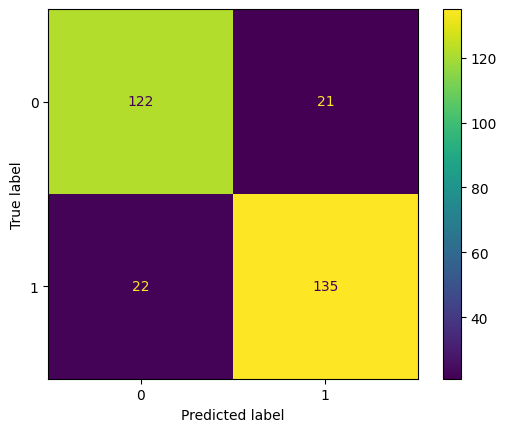

In [ ]:
(xTemp, yTemp), (xIMDB, yIMDB) = keras.datasets.imdb.load_data(num_words=vocab_size)
dictIMDB = keras.datasets.imdb.get_word_index()

xIMDB = keras.utils.pad_sequences(xIMDB, maxlen=maxlen)

exampleCount = 300

# First select text bodies from IMDB set
xTestIMDB, yTestIMDB = selectTextBody(xIMDB, yIMDB, exampleCount)

# Perform class prediction on set
# Class 0 is negative review, class 1 is positive review
predictClass(model, xTestIMDB, yTestIMDB, reverseDict(dictIMDB))

## Part III: Variational Autoencoder for Image Analysis

### Pytorch Implementation

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [ ]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 398811607.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34325784.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 132030533.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3488468.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



====> Test set loss: 544.3516
====> Epoch: 1 Average loss: 191.3294
====> Test set loss: 137.4491
====> Epoch: 2 Average loss: 134.0651
====> Test set loss: 116.1816
====> Epoch: 3 Average loss: 121.1424
====> Test set loss: 108.3618
====> Epoch: 4 Average loss: 115.9439
====> Test set loss: 104.7329
====> Epoch: 5 Average loss: 113.2100
====> Test set loss: 102.4974
====> Epoch: 6 Average loss: 111.4241
====> Test set loss: 100.9748
====> Epoch: 7 Average loss: 110.1519
====> Test set loss: 100.1282
====> Epoch: 8 Average loss: 109.2362
====> Test set loss: 99.4310
====> Epoch: 9 Average loss: 108.4444
====> Test set loss: 98.3707
====> Epoch: 10 Average loss: 107.8107
====> Test set loss: 98.5929


<ipython-input-20-4b96edbba8ab>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


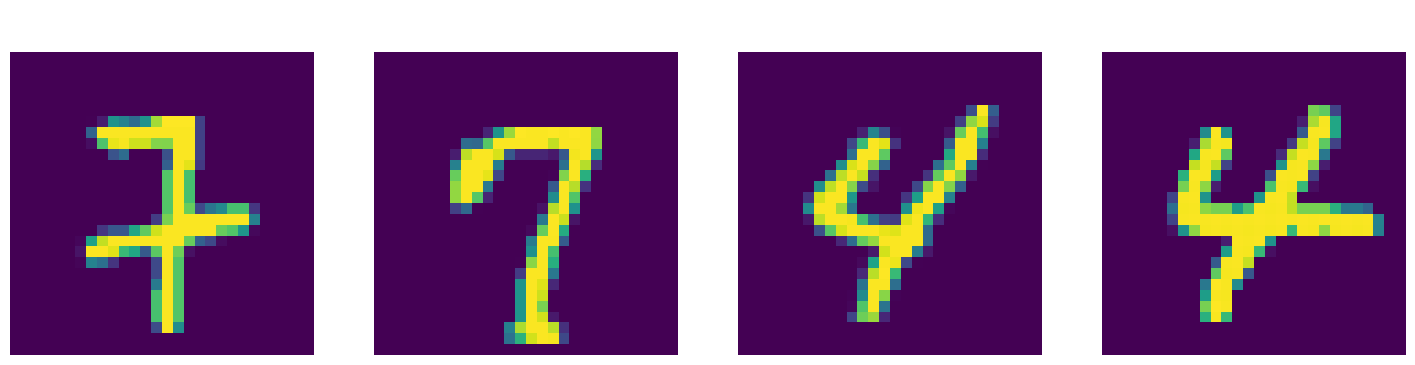

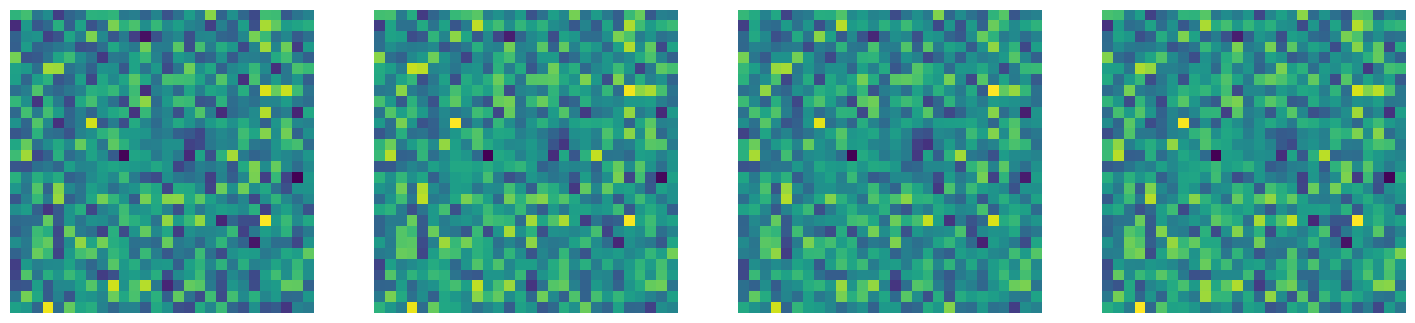

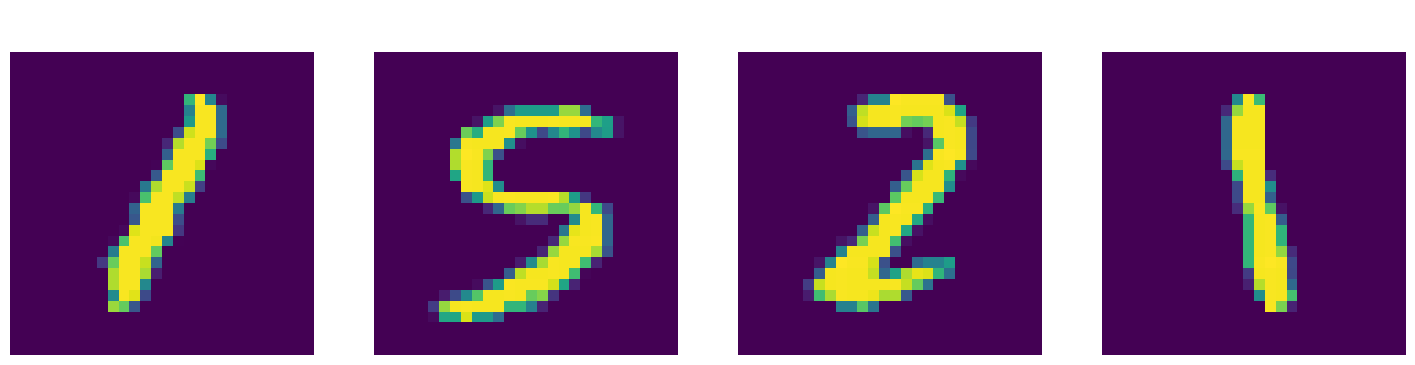

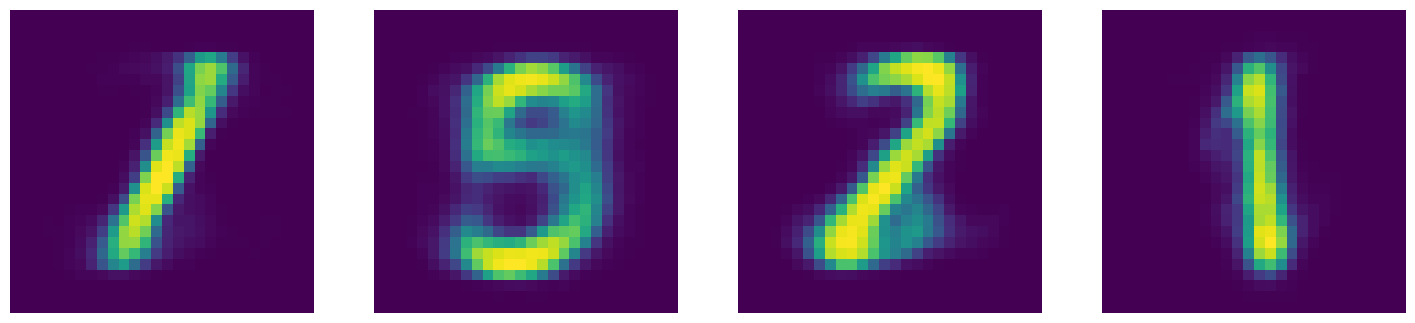

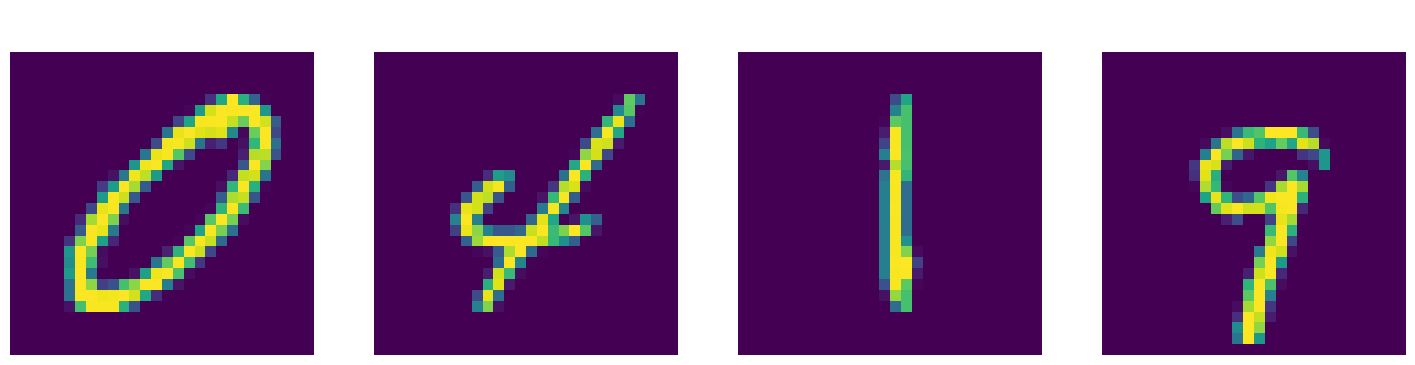

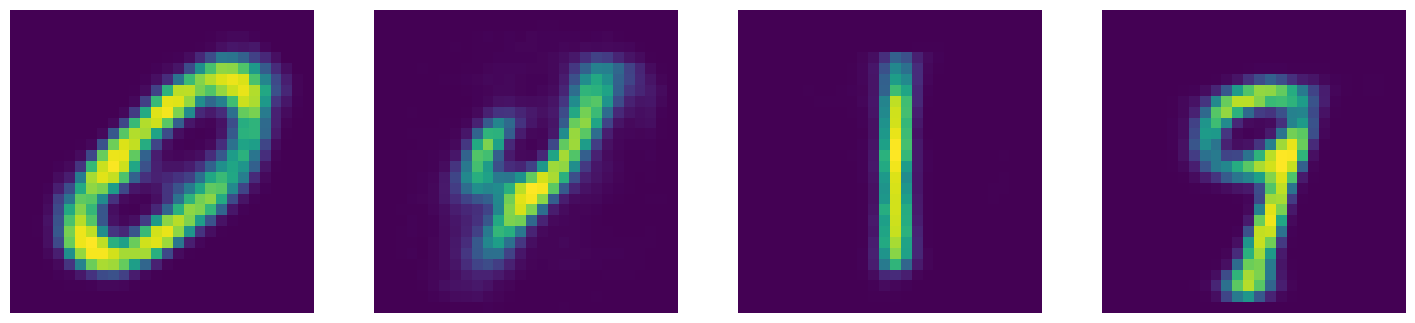

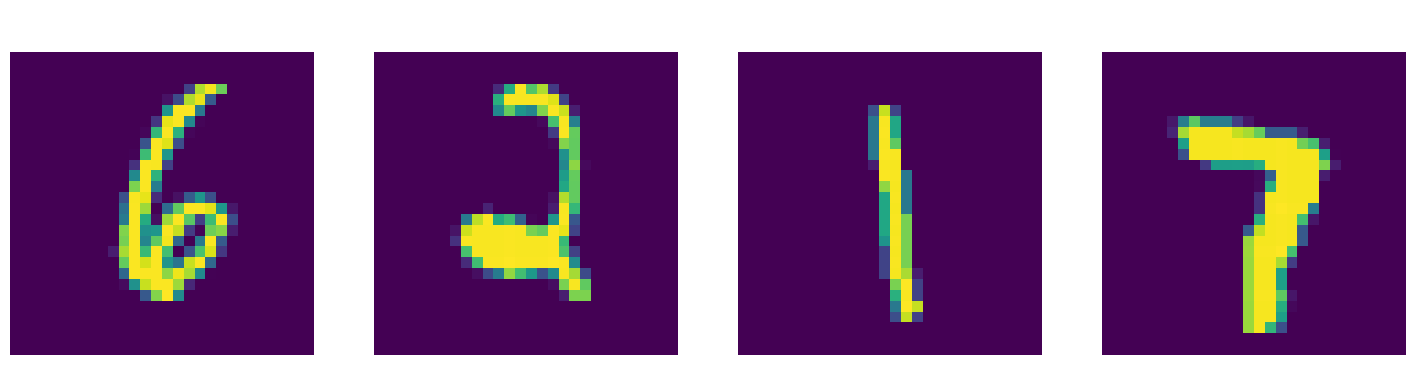

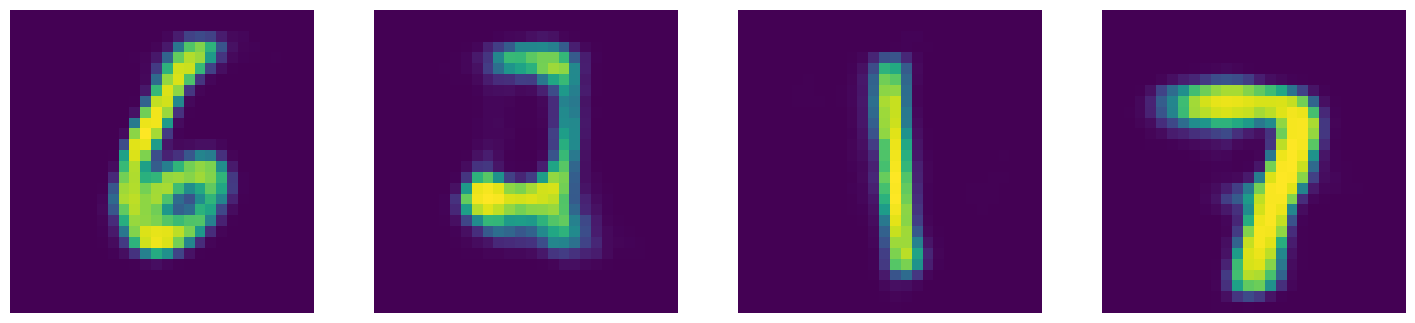

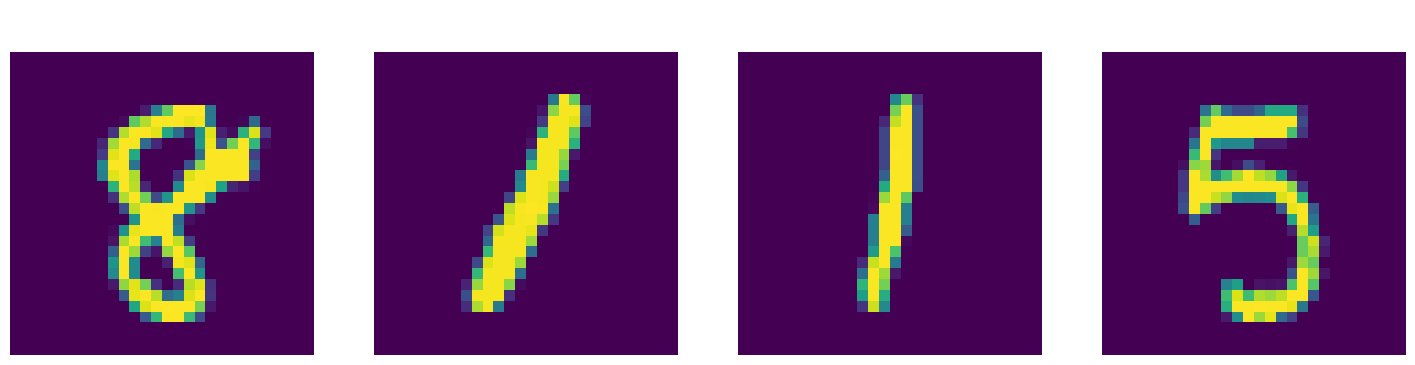

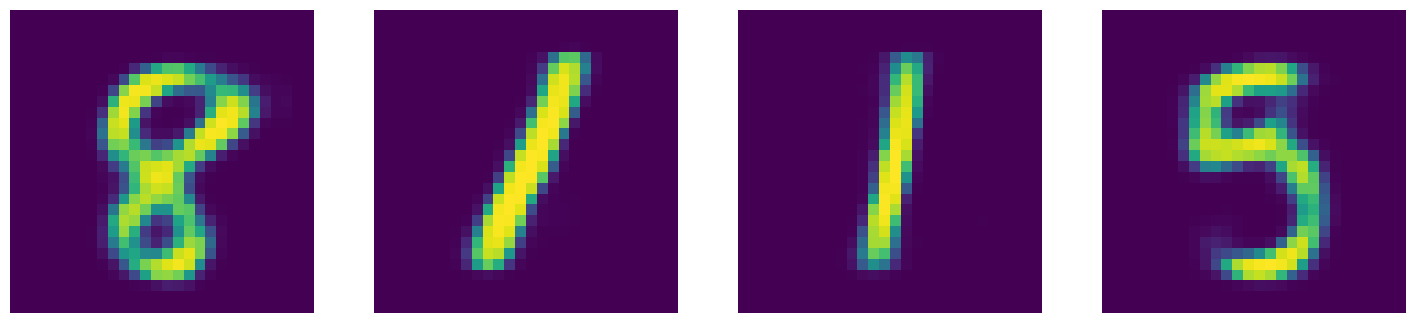

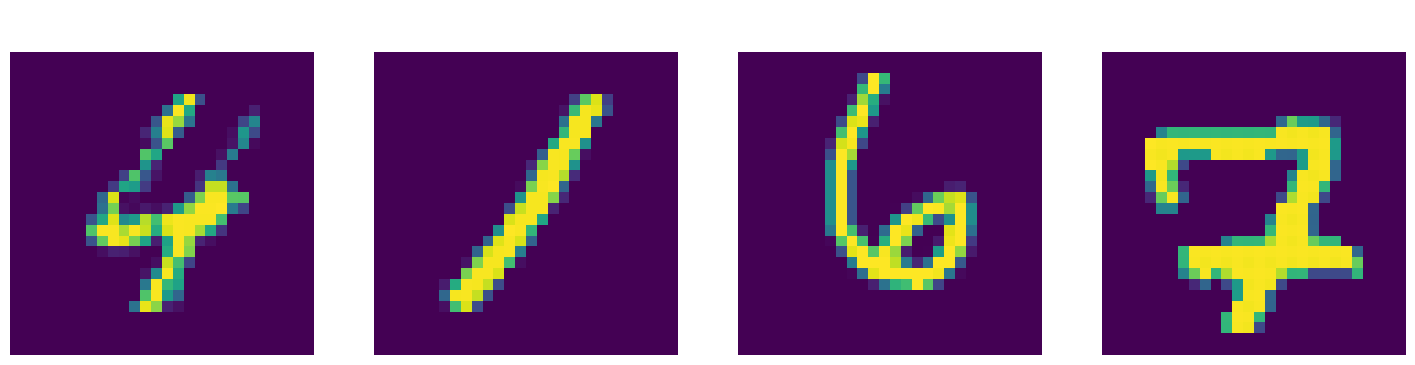

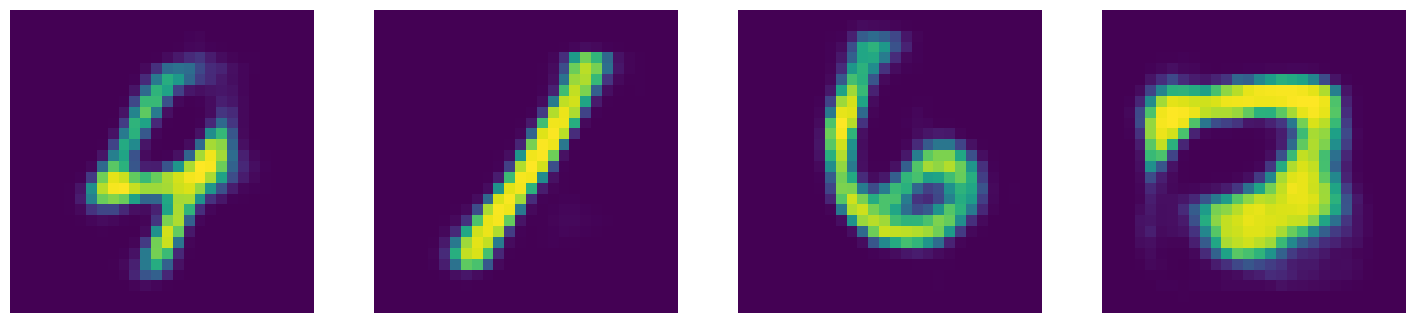

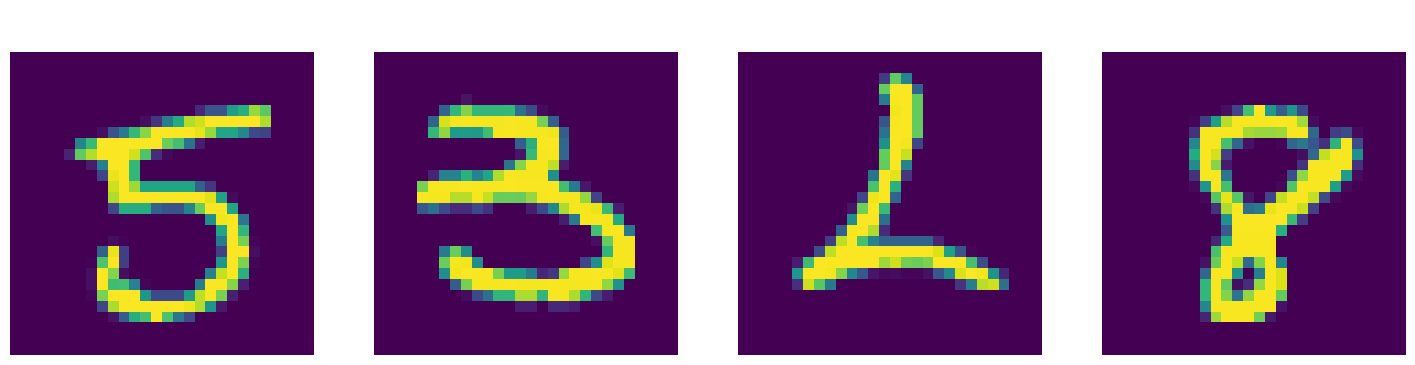

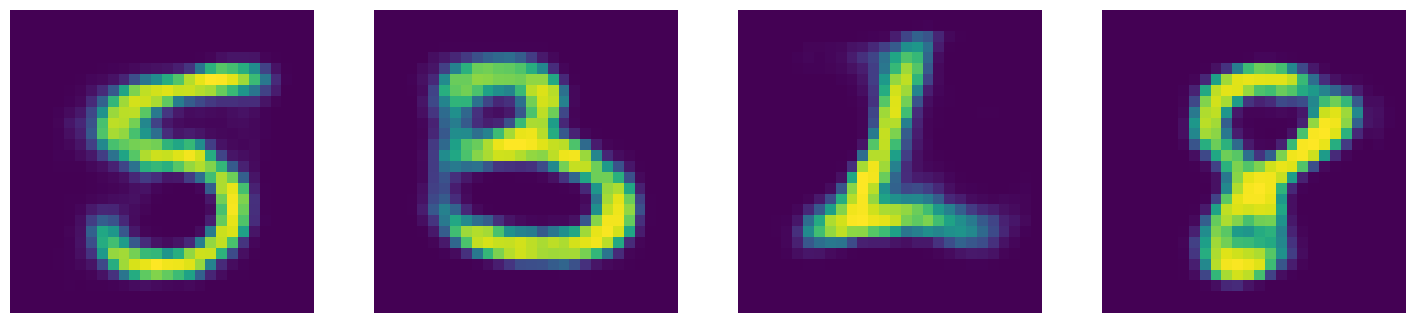

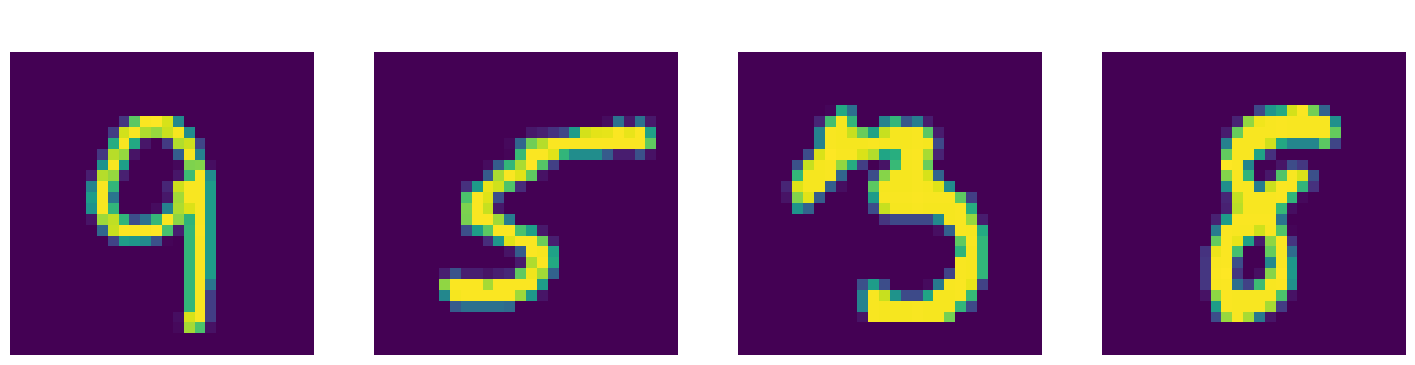

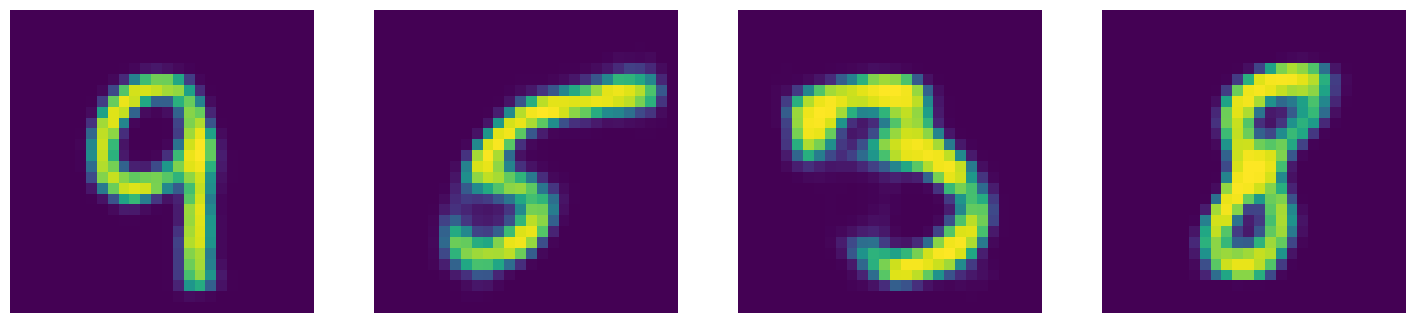

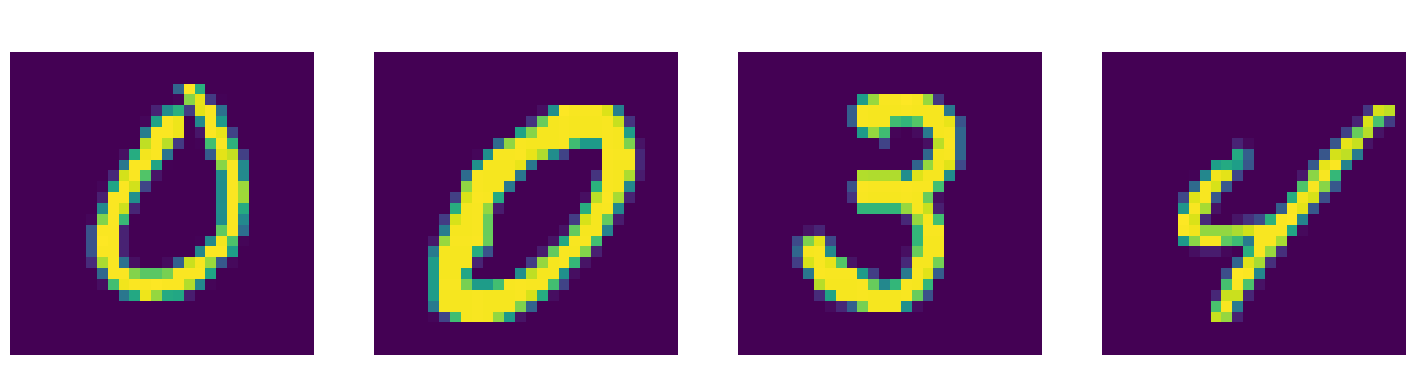

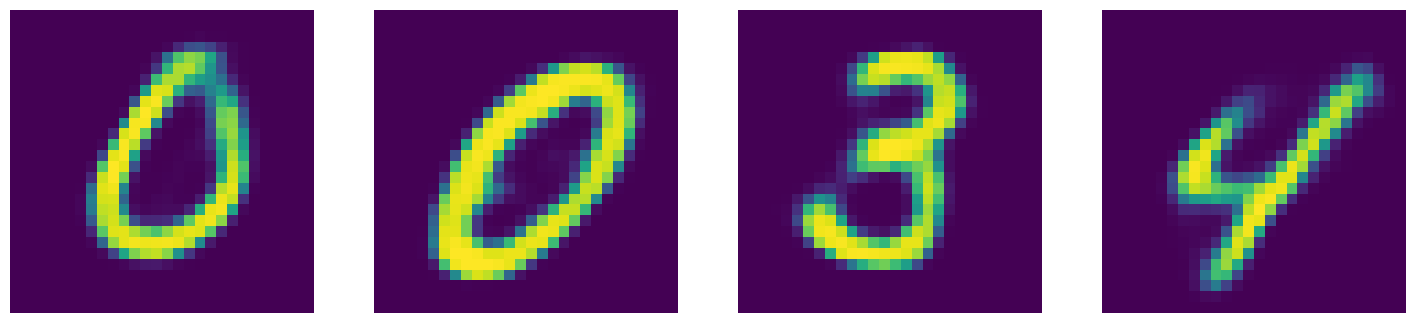

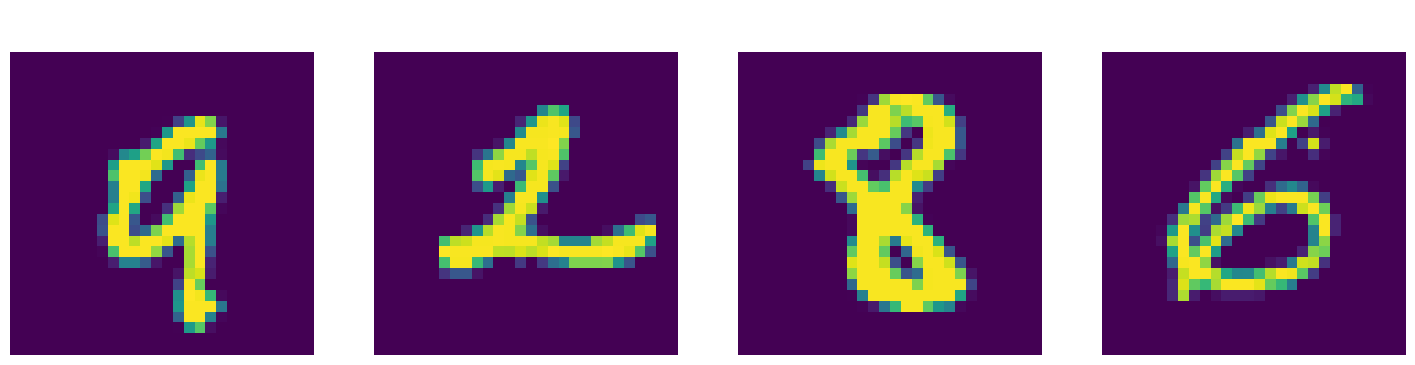

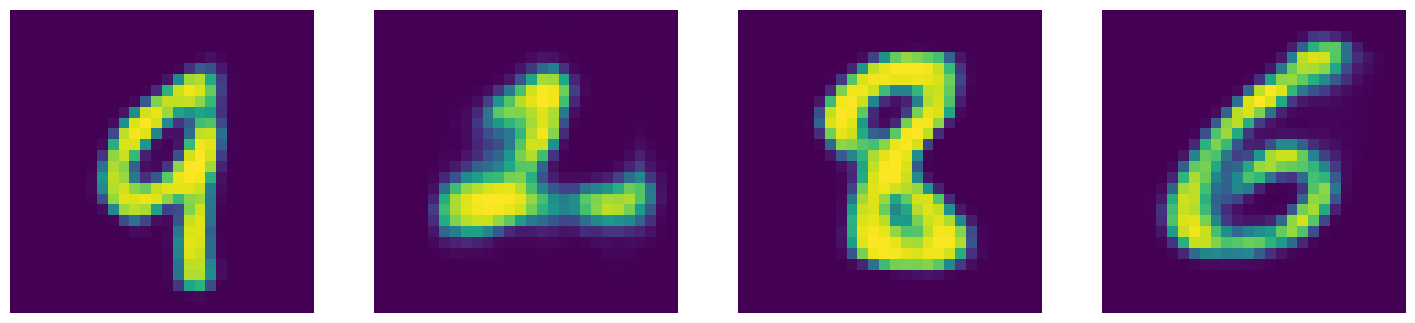

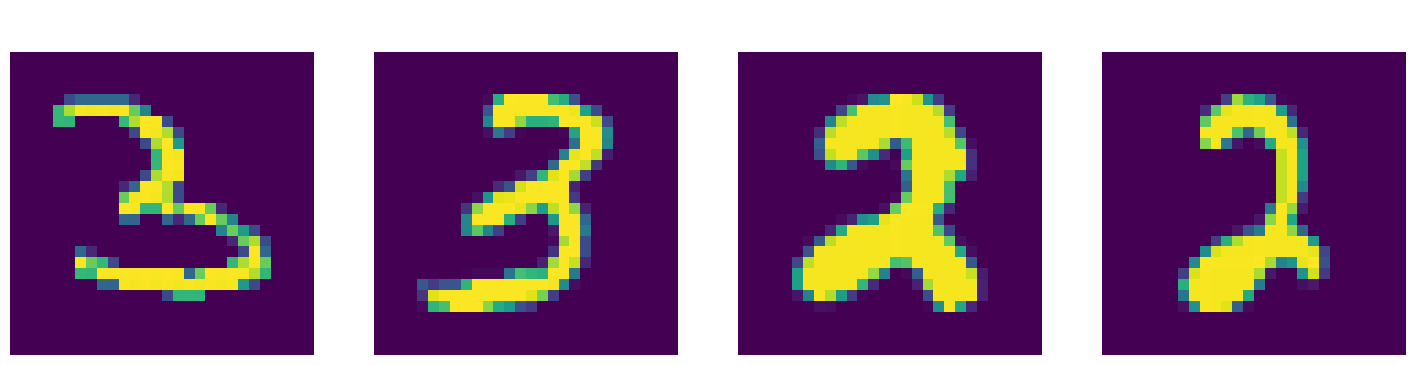

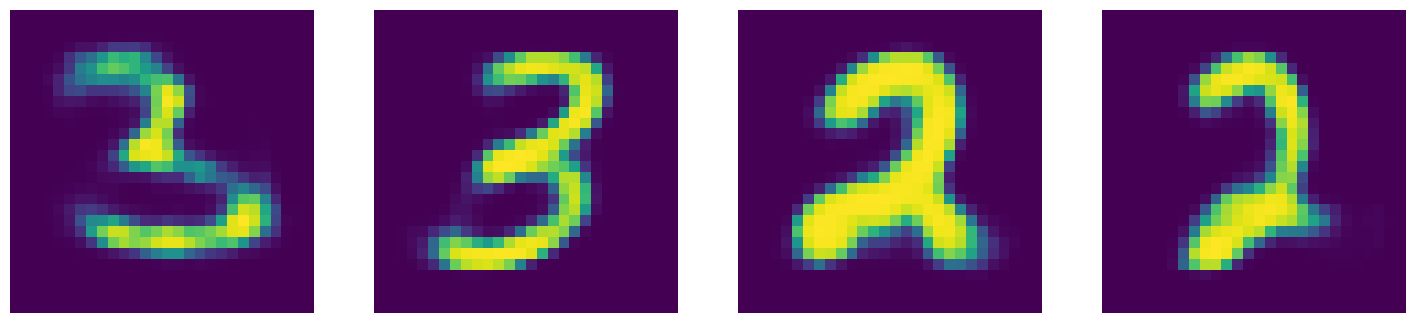

In [ ]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # Testing

    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

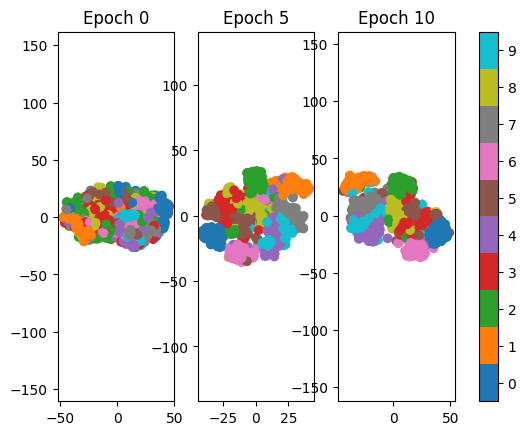

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

### Tensorflow Implementation

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [12]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = tf.reshape(in_, (-1, 28, 28))
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = tf.reshape(out, (-1, 28, 28))
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [13]:
batch_size = 256

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(batch_size)
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(1000).batch(batch_size)

In [14]:
class VAE(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = keras.Sequential([
            keras.layers.InputLayer((28, 28, 1)),
            keras.layers.Flatten(),
            keras.layers.Dense(400, activation="relu"),
            keras.layers.Dense(2 * 20),
        ])

        self.decoder = keras.Sequential([
            keras.layers.Dense(400, activation="relu"),
            keras.layers.Dense(28 * 28, activation="sigmoid"),
            keras.layers.Reshape((28, 28, 1)),
        ])

    @tf.function
    def reparameterize(self, mu, logvar):
        if self._get_trainable_state():
            std = tf.exp(logvar * 0.5)
            eps = tf.random.normal(std.shape)
            return eps * std + mu
        else:
            return mu

    def call(self, x, training=False):
        mu_logvar = self.encoder(x)
        mu, logvar = tf.split(mu_logvar, 2, axis=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

In [15]:
def loss_function(x_hat, x, mu, logvar, beta=1):
    bce = tf.keras.losses.binary_crossentropy(x, x_hat)
    bce = tf.reduce_sum(bce)
    kld = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
    return bce + beta * kld

In [16]:
epochs = 10
codes = {'μ': [], 'logσ2': [], 'y': []}

for epoch in range(epochs + 1):
    # Training
    if epoch > 0:  # Test untrained net first
        train_loss = tf.keras.metrics.Mean()
        for x, _ in train_loader:
            with tf.GradientTape() as tape:
                x_hat, mu, logvar = model(x, training=True)
                loss = loss_function(x_hat, x, mu, logvar)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            train_loss(loss / len(train_loader))
        print(f'====> Epoch: {epoch} Average loss: {train_loss.result():.4f}')

    # Testing
    means, logvars, labels = [], [], []

    test_loss = tf.keras.metrics.Mean()
    for x, y in test_loader:
        x_hat, mu, logvar = model(x, training=False)
        loss = loss_function(x_hat, x, mu, logvar)
        test_loss(loss / len(test_loader))
        means.append(mu)
        logvars.append(logvar)
        labels.append(y)

    codes['μ'].append(tf.concat(means, axis=0))
    codes['logσ2'].append(tf.concat(logvars, axis=0))
    codes['y'].append(tf.concat(labels, axis=0))

    print(f'====> Test set loss: {test_loss.result():.4f}')


====> Test set loss: 3444.1301
====> Epoch: 1 Average loss: 209.2179
====> Test set loss: 905.7690
====> Epoch: 2 Average loss: 145.1625
====> Test set loss: 781.2985
====> Epoch: 3 Average loss: 132.9050
====> Test set loss: 740.2908
====> Epoch: 4 Average loss: 127.7601
====> Test set loss: 718.8454
====> Epoch: 5 Average loss: 124.5996
====> Test set loss: 703.8819
====> Epoch: 6 Average loss: 122.4732
====> Test set loss: 693.9302
====> Epoch: 7 Average loss: 120.8771
====> Test set loss: 688.3119
====> Epoch: 8 Average loss: 119.6358
====> Test set loss: 681.7695
====> Epoch: 9 Average loss: 118.6751
====> Test set loss: 677.9609
====> Epoch: 10 Average loss: 117.8951
====> Test set loss: 672.9784


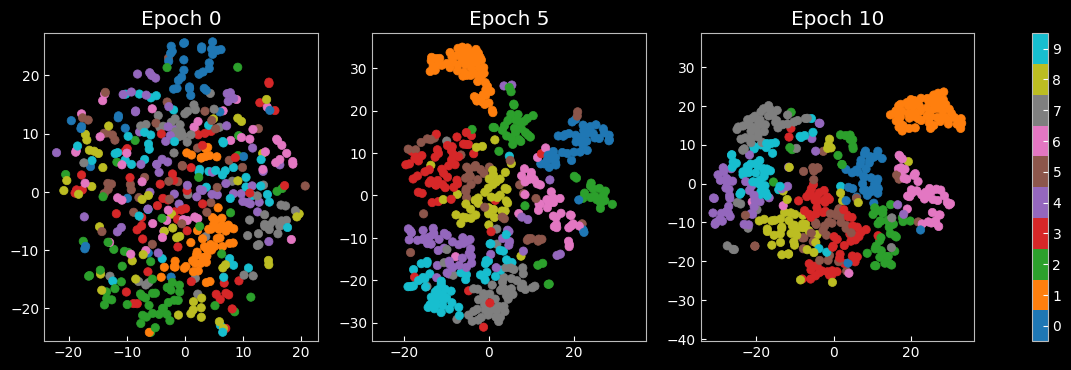

In [17]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

set_default(figsize=(15, 4))

X, Y, E = [], [], []  # input, classes, embeddings
n_samples_per_epoch = 500  # Adjust this value for fewer samples per epoch
epochs = (0, 5, 10)

# Generate and plot t-SNE embeddings for each epoch
for epoch in epochs:
    x_epoch = codes['μ'][epoch][:n_samples_per_epoch]
    y_epoch = codes['y'][epoch][:n_samples_per_epoch]

    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(x_epoch)
    X.append(x_epoch)
    E.append(embeddings)
    Y.append(y_epoch)

# Plot all epochs' embeddings in one figure
f, a = plt.subplots(ncols=len(epochs))
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:, 0], E[i][:, 1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')

f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - 0.5)
plt.show()


### Nadam Optimizer

====> Test set loss: 3434.5859
====> Epoch: 1 Average loss: 202.9750
====> Test set loss: 868.6989
====> Epoch: 2 Average loss: 142.6533
====> Test set loss: 777.3724
====> Epoch: 3 Average loss: 132.6497
====> Test set loss: 740.5424
====> Epoch: 4 Average loss: 127.7719
====> Test set loss: 719.1396
====> Epoch: 5 Average loss: 124.7680
====> Test set loss: 704.8280
====> Epoch: 6 Average loss: 122.5968
====> Test set loss: 695.8610
====> Epoch: 7 Average loss: 120.9861
====> Test set loss: 687.9016
====> Epoch: 8 Average loss: 119.7659
====> Test set loss: 681.8447
====> Epoch: 9 Average loss: 118.7708
====> Test set loss: 677.0518
====> Epoch: 10 Average loss: 117.9517
====> Test set loss: 672.7449


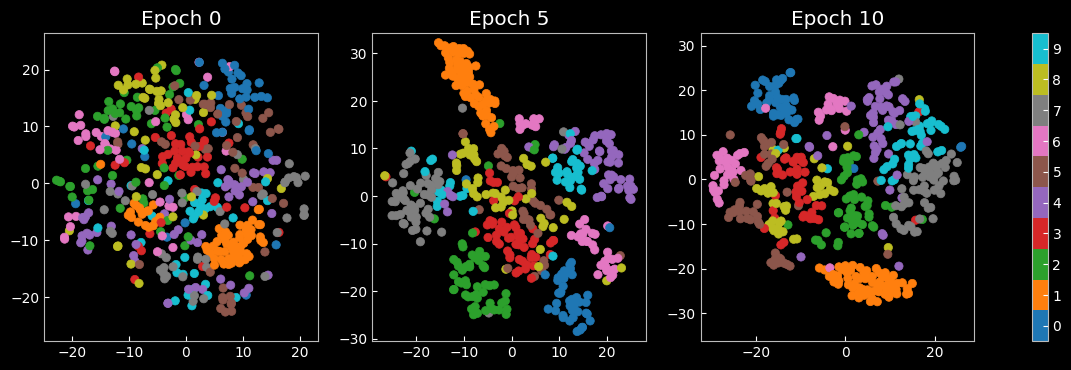

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = tf.reshape(in_, (-1, 28, 28))
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = tf.reshape(out, (-1, 28, 28))
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

batch_size = 256

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(batch_size)
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(1000).batch(batch_size)

class VAE(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = keras.Sequential([
            keras.layers.InputLayer((28, 28, 1)),
            keras.layers.Flatten(),
            keras.layers.Dense(400, activation="relu"),
            keras.layers.Dense(2 * 20),
        ])

        self.decoder = keras.Sequential([
            keras.layers.Dense(400, activation="relu"),
            keras.layers.Dense(28 * 28, activation="sigmoid"),
            keras.layers.Reshape((28, 28, 1)),
        ])

    @tf.function
    def reparameterize(self, mu, logvar):
        if self._get_trainable_state():
            std = tf.exp(logvar * 0.5)
            eps = tf.random.normal(std.shape)
            return eps * std + mu
        else:
            return mu

    def call(self, x, training=False):
        mu_logvar = self.encoder(x)
        mu, logvar = tf.split(mu_logvar, 2, axis=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE()
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

def loss_function(x_hat, x, mu, logvar, beta=1):
    bce = tf.keras.losses.binary_crossentropy(x, x_hat)
    bce = tf.reduce_sum(bce)
    kld = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
    return bce + beta * kld

epochs = 10
codes = {'μ': [], 'logσ2': [], 'y': []}

for epoch in range(epochs + 1):
    # Training
    if epoch > 0:  # Test untrained net first
        train_loss = tf.keras.metrics.Mean()
        for x, _ in train_loader:
            with tf.GradientTape() as tape:
                x_hat, mu, logvar = model(x, training=True)
                loss = loss_function(x_hat, x, mu, logvar)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            train_loss(loss / len(train_loader))
        print(f'====> Epoch: {epoch} Average loss: {train_loss.result():.4f}')

    # Testing
    means, logvars, labels = [], [], []

    test_loss = tf.keras.metrics.Mean()
    for x, y in test_loader:
        x_hat, mu, logvar = model(x, training=False)
        loss = loss_function(x_hat, x, mu, logvar)
        test_loss(loss / len(test_loader))
        means.append(mu)
        logvars.append(logvar)
        labels.append(y)

    codes['μ'].append(tf.concat(means, axis=0))
    codes['logσ2'].append(tf.concat(logvars, axis=0))
    codes['y'].append(tf.concat(labels, axis=0))

    print(f'====> Test set loss: {test_loss.result():.4f}')

from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

set_default(figsize=(15, 4))

X, Y, E = [], [], []  # input, classes, embeddings
n_samples_per_epoch = 500  # Adjust this value for fewer samples per epoch
epochs = (0, 5, 10)

# Generate and plot t-SNE embeddings for each epoch
for epoch in epochs:
    x_epoch = codes['μ'][epoch][:n_samples_per_epoch]
    y_epoch = codes['y'][epoch][:n_samples_per_epoch]

    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(x_epoch)
    X.append(x_epoch)
    E.append(embeddings)
    Y.append(y_epoch)

# Plot all epochs' embeddings in one figure
f, a = plt.subplots(ncols=len(epochs))
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:, 0], E[i][:, 1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')

f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - 0.5)
plt.show()


### Regularization experimentation

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = tf.reshape(in_, (-1, 28, 28))
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1, 4, i + 1)
                plt.imshow(in_pic[i + 4 * N])
                plt.axis('off')
        out_pic = tf.reshape(out, (-1, 28, 28))
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.imshow(out_pic[i + 4 * N])
            plt.axis('off')
            if count:
                plt.title(str(4 * N + i), color='w')

batch_size = 256

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(batch_size)
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(1000).batch(batch_size)

class VAE(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = keras.Sequential([
            keras.layers.InputLayer((28, 28, 1)),
            keras.layers.Flatten(),
            keras.layers.Dense(400, activation="relu"),
            keras.layers.Dense(2 * 20),
        ])

        self.decoder = keras.Sequential([
            keras.layers.Dense(400, activation="relu"),
            keras.layers.Dense(28 * 28, activation="sigmoid"),
            keras.layers.Reshape((28, 28, 1)),
        ])

    @tf.function
    def reparameterize(self, mu, logvar):
        if self._get_trainable_state():
            std = tf.exp(logvar * 0.5)
            eps = tf.random.normal(std.shape)
            return eps * std + mu
        else:
            return mu

    def call(self, x, training=False):
        mu_logvar = self.encoder(x)
        mu, logvar = tf.split(mu_logvar, 2, axis=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(x_hat, x, mu, logvar, beta=1.0):  # Added beta parameter with a default value of 1.0
    bce = tf.keras.losses.binary_crossentropy(x, x_hat)
    bce = tf.reduce_sum(bce)
    kld = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
    return bce + beta * kld

optimizer = keras.optimizers.legacy.Nadam(learning_rate=1e-3)

# Experimenting with different beta values
beta_values = [0.1, 0.5, 1.0, 2.0]  # Add more beta values to experiment

for beta_value in beta_values:
    print(f"Training with kl = {beta_value}")

    model = VAE()

    epochs = 10
    codes = {'μ': [], 'logσ2': [], 'y': []}

    for epoch in range(epochs + 1):
        # Training
        if epoch > 0:  # Test untrained net first
            train_loss = tf.keras.metrics.Mean()
            for x, _ in train_loader:
                with tf.GradientTape() as tape:
                    x_hat, mu, logvar = model(x, training=True)
                    loss = loss_function(x_hat, x, mu, logvar, beta=beta_value)  # Pass beta value here
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                train_loss(loss / len(train_loader))
            print(f'====> Epoch: {epoch} Average loss: {train_loss.result():.4f}')

        # Testing
        means, logvars, labels = [], [], []

        test_loss = tf.keras.metrics.Mean()
        for x, y in test_loader:
            x_hat, mu, logvar = model(x, training=False)
            loss = loss_function(x_hat, x, mu, logvar, beta=beta_value)  # Pass beta value here
            test_loss(loss / len(test_loader))
            means.append(mu)
            logvars.append(logvar)
            labels.append(y)

        codes['μ'].append(tf.concat(means, axis=0))
        codes['logσ2'].append(tf.concat(logvars, axis=0))
        codes['y'].append(tf.concat(labels, axis=0))

        print(f'====> Test set loss: {test_loss.result():.4f}')


Training with kl = 0.1
====> Test set loss: 3432.8042
====> Epoch: 1 Average loss: 171.3748
====> Test set loss: 685.3433
====> Epoch: 2 Average loss: 111.4281
====> Test set loss: 592.6569
====> Epoch: 3 Average loss: 101.2242
====> Test set loss: 555.4029
====> Epoch: 4 Average loss: 96.4368
====> Test set loss: 536.3923
====> Epoch: 5 Average loss: 93.3131
====> Test set loss: 521.4609
====> Epoch: 6 Average loss: 91.0777
====> Test set loss: 512.0363
====> Epoch: 7 Average loss: 89.3282
====> Test set loss: 503.5618
====> Epoch: 8 Average loss: 87.9188
====> Test set loss: 497.6884
====> Epoch: 9 Average loss: 86.7512
====> Test set loss: 490.4102
====> Epoch: 10 Average loss: 85.7236
====> Test set loss: 485.8568
Training with kl = 0.5
====> Test set loss: 3422.8933
====> Epoch: 1 Average loss: 172.3679
====> Test set loss: 804.3882
====> Epoch: 2 Average loss: 132.6512
====> Test set loss: 719.5021
====> Epoch: 3 Average loss: 123.2282
====> Test set loss: 684.8687
====> Epoch: 4

Visualizing t-SNE embeddings for beta = 0.1


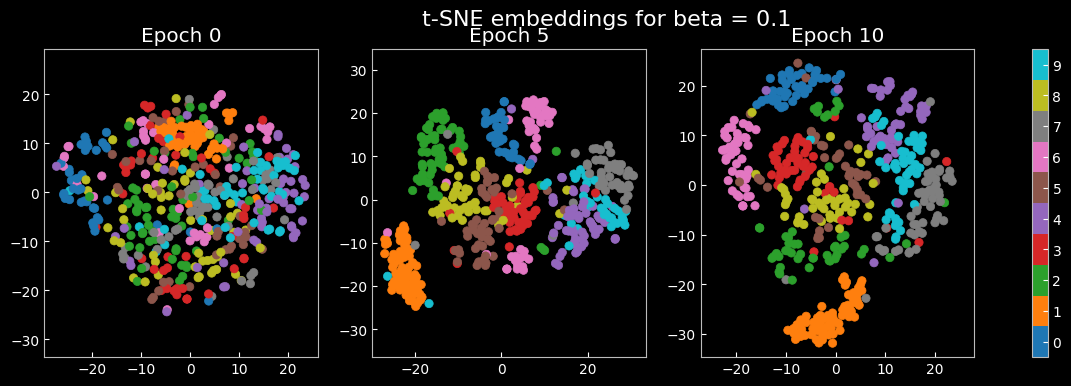

Visualizing t-SNE embeddings for beta = 0.5


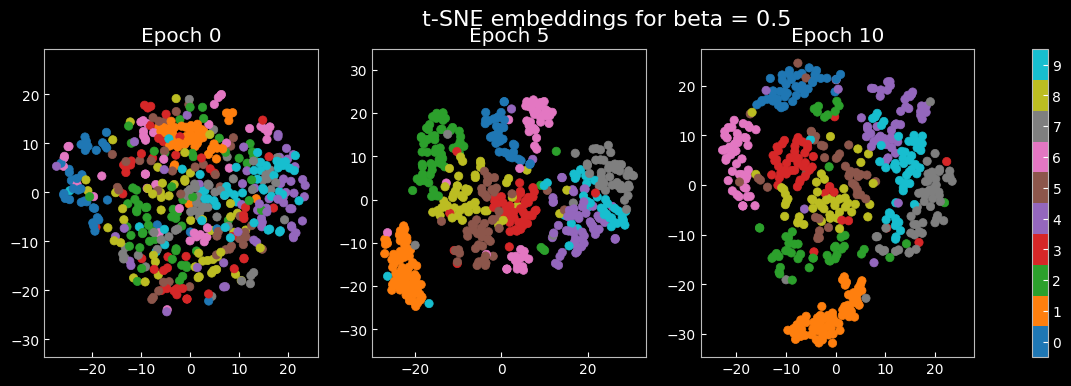

Visualizing t-SNE embeddings for beta = 1.0


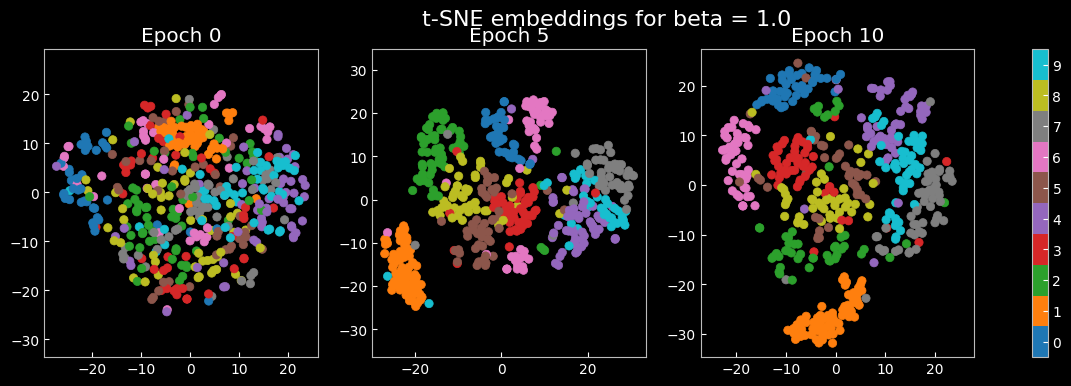

Visualizing t-SNE embeddings for beta = 2.0


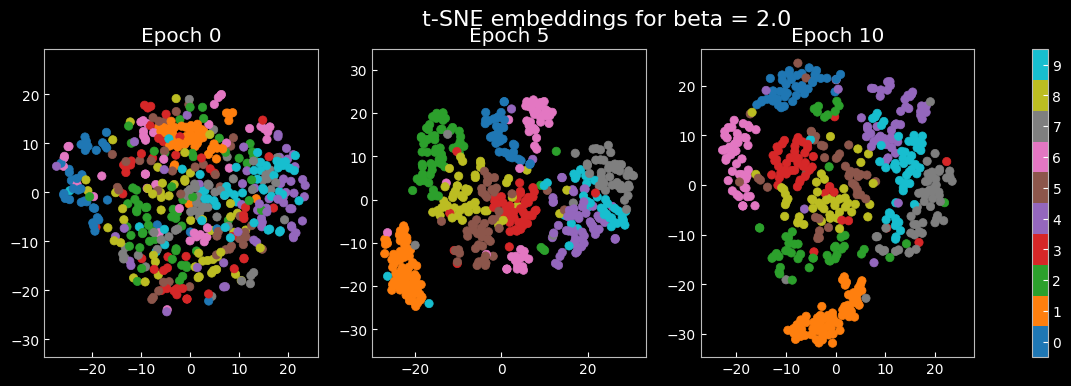

In [6]:
# Visualization code for t-SNE embeddings
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

set_default(figsize=(15, 4))

X, Y, E = [], [], []  # input, classes, embeddings
n_samples_per_epoch = 500  # Adjust this value for fewer samples per epoch
epochs = (0, 5, 10)

# Generate and plot t-SNE embeddings for each epoch and beta value
for beta_value in beta_values:
    print(f"Visualizing t-SNE embeddings for beta = {beta_value}")

    for epoch in epochs:
        model = VAE()
        # Rest of the training code...
        # ...

        x_epoch = codes['μ'][epoch][:n_samples_per_epoch]
        y_epoch = codes['y'][epoch][:n_samples_per_epoch]

        tsne = TSNE(n_components=2)
        embeddings = tsne.fit_transform(x_epoch)
        X.append(x_epoch)
        E.append(embeddings)
        Y.append(y_epoch)

    # Plot all epochs' embeddings in one figure for this beta value
    f, a = plt.subplots(ncols=len(epochs))
    for i, e in enumerate(epochs):
        s = a[i].scatter(E[i][:, 0], E[i][:, 1], c=Y[i], cmap='tab10')
        a[i].grid(False)
        a[i].set_title(f'Epoch {e}')
        a[i].axis('equal')

    f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - 0.5)
    plt.suptitle(f"t-SNE embeddings for beta = {beta_value}", color='w', fontsize=16)
    plt.show()